In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import re
from scipy.optimize import curve_fit
from scipy.constants import k as kb
from scipy.constants import N_A as NA

In [2]:
def load_file(filenm):
    """
    Load xvg - file and return a pandas dataframe. 
    """
    data = []
    with open(filenm) as f:
        for line in f:
            #If line starts with @ or #, skip
            if line.startswith(('#', '@')):
                continue
            data.append([float(x) for x in re.split(r'\s+', line.strip())])
    return pd.DataFrame(data, columns=['time', 'value'])

In [41]:
def compute_potential(A, bins=100, T=300, k=kb):
    """
    Compute potential function of parameter sampled in A from the probabillity distribution using Bolzmanns inverse law.
    """
    hist, edges = np.histogram(A, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    pot = -np.log(hist)*k*T
    pot *= NA/1000
    centers = centers[np.isfinite(pot)]
    pot = pot[np.isfinite(pot)]
    pot -= pot.min()
    return centers, pot



In [36]:
def proper_dihedral(phi, phi0, k, n):
    """
    Compute dihedral angle using the proper dihedral angle function.
    """
    phi = np.deg2rad(phi)
    phi0 = np.deg2rad(phi0)
    return k*(1+np.cos(n*phi-phi0))

In [105]:
def quartic_angle(theta, theta0, C2, C4):
    theta = np.deg2rad(theta)
    theta0 = np.deg2rad(theta0)
    return C2 * (theta - theta0)**2 + C4 * (theta - theta0)**4

In [119]:
def fit_param(filenm, func, p0, range=(-180, 180)):
    df = load_file(filenm)
    centers_dih4, pot_dih4 = compute_potential(df['value'])
    popt, pcov = curve_fit(func, centers_dih4, pot_dih4, p0=p0)
    plt.scatter(centers_dih4, pot_dih4, label='data')
    print(f'optimal parameters: {popt}')
    x = np.linspace(*range, 100)
    plt.plot(x, func(x, *popt), label='fit')
    plt.legend()
    plt.show()
    return popt

optimal parameters: [139.98201594 134.77990708]


/tmp/ipykernel_1310227/3893144688.py:7: RuntimeWarning: divide by zero encountered in log
  pot = -np.log(hist)*k*T


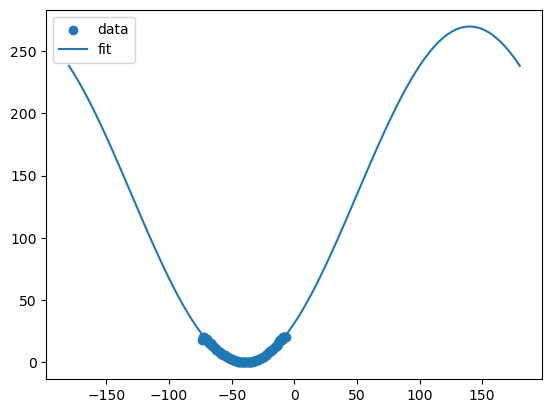

optimal parameters: [100.01525368  27.87964097]


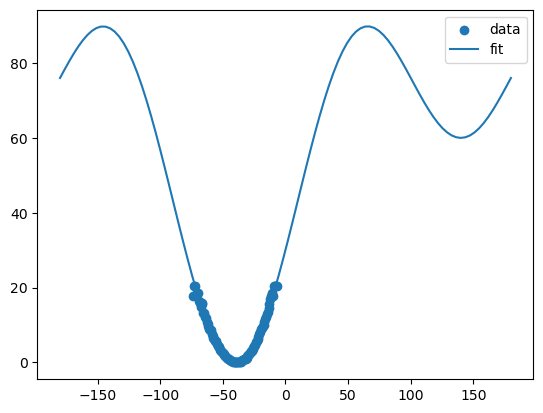

In [120]:
fn = 'reference/dihedrals_mapped/dih_3.xvg'
popt1 = fit_param(fn, lambda x, phi0, k: proper_dihedral(x, phi0, k, 1), [140,20])
func2 = lambda x, phi0, k: proper_dihedral(x, phi0, k, 2) + proper_dihedral(x, popt1[0], 30, 1)
potp2 = fit_param(fn, func2, [140,20])

optimal parameters: [-59.81270177 147.52094397]


/tmp/ipykernel_1310227/3893144688.py:7: RuntimeWarning: divide by zero encountered in log
  pot = -np.log(hist)*k*T


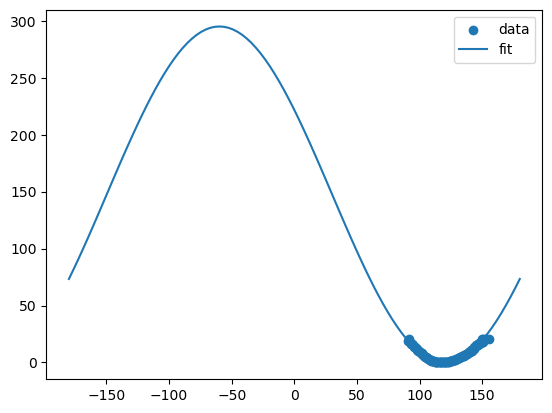

array([-59.81270177, 147.52094397])

In [109]:
fn = 'reference/dihedrals_mapped/dih_4.xvg'
fit_param(fn, lambda x, phi0, k: proper_dihedral(x, phi0, k, 1), [-60,10])

/tmp/ipykernel_1310227/3893144688.py:7: RuntimeWarning: divide by zero encountered in log
  pot = -np.log(hist)*k*T


optimal parameters: [  93.8528333   181.78991394 -169.09673512]


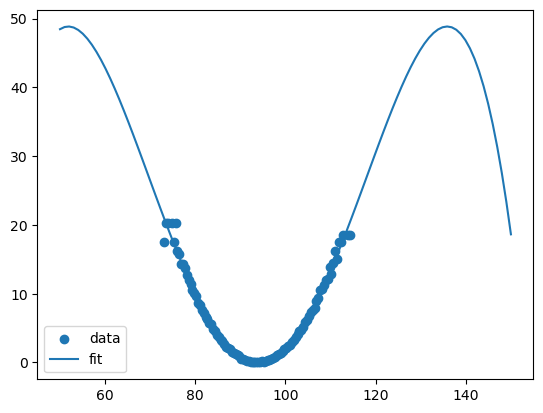

array([  93.8528333 ,  181.78991394, -169.09673512])

In [122]:
fn = 'reference/angles_mapped/ang_3.xvg'
fit_param(fn, quartic_angle, [90, -100, 500], (50,150))